<a href="https://colab.research.google.com/github/HilbertN/Analisis_de_datos_Tareas/blob/main/Tarea4_RedesNeuronales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models,regularizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Activation,MaxPooling2D,Flatten,Conv2D
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.losses import CategoricalCrossentropy,MeanSquaredError
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import  image
import pandas as pd 
import numpy as np
import shutil 
import os
import matplotlib.pyplot as plt

In [2]:
# Weights & Biases  (optional)
!pip install -q wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.5/206.5 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.5 MB/s eta 0:00:00


In [3]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
#Ejercicio 1: Entrena una red neuronal para que reproduzca la siguientes funciones en el  intervalo  de  [-1,1].  
# Graficar  la  solución  de  la  red  en  conjunto  con  la gráfica de la función.(a)  3 sin(πx)(b)  1 + 2x+ 4x3

#Ejercicio 1(a): 
#Vamos a proponer los siguientes arreglos como conjuntos de entranmiento y de prueba 

x_train = np.linspace(-1, 1, 1000).reshape(-1, 1)
y_train = 3 * np.sin(np.pi * x_train)

#Eliminamos elementos repetidos entre el conjunto de entrenamiento y de prueba
v=np.linspace(-1, 1, 100)
cond=np.isin(np.linspace(-1, 1, 100),np.linspace(-1, 1, 1000))
v=v[np.where(~cond)]

x_test = v.reshape(-1, 1)
y_test= 3 * np.sin(np.pi * x_test)


In [5]:
#No hay elementos repetidos entre el conjunto de prueba y entrenamiento
h1=set(np.linspace(-1, 1, 1000))
h3=set(v)
Repetidos=list(h3.intersection(h1))
Repetidos

[]

In [6]:
model = Sequential()
model.add(Dense(300, activation='relu', input_shape=(1,)))
model.add(Dropout(0.2))
model.add(Dense(300, activation='relu'))
model.add(Dense(1))




In [7]:
batch_size=30 
epochs=40 
learning_rate=0.03
Optimizador=SGD

In [8]:
model.compile(loss='mean_squared_error', optimizer=Optimizador(learning_rate=learning_rate), metrics=['mse'])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test))

Epoch 1/40
34/34 [==============================] - 1s 10ms/step - loss: 2.4412 - mse: 2.4412 - val_loss: 1.0586 - val_mse: 1.0586
Epoch 2/40
34/34 [==============================] - 0s 8ms/step - loss: 1.0893 - mse: 1.0893 - val_loss: 0.9402 - val_mse: 0.9402
Epoch 3/40
34/34 [==============================] - 0s 11ms/step - loss: 0.9551 - mse: 0.9551 - val_loss: 0.8432 - val_mse: 0.8432
Epoch 4/40
34/34 [==============================] - 0s 14ms/step - loss: 0.8717 - mse: 0.8717 - val_loss: 0.8653 - val_mse: 0.8653
Epoch 5/40
34/34 [==============================] - 0s 13ms/step - loss: 0.7499 - mse: 0.7499 - val_loss: 0.5770 - val_mse: 0.5770
Epoch 6/40
34/34 [==============================] - 0s 13ms/step - loss: 0.5993 - mse: 0.5993 - val_loss: 0.4362 - val_mse: 0.4362
Epoch 7/40
34/34 [==============================] - 0s 15ms/step - loss: 0.4609 - mse: 0.4609 - val_loss: 0.3185 - val_mse: 0.3185
Epoch 8/40
34/34 [==============================] - 0s 13ms/step - loss: 0.3228 - ms

4/4 [==============================] - 0s 4ms/step


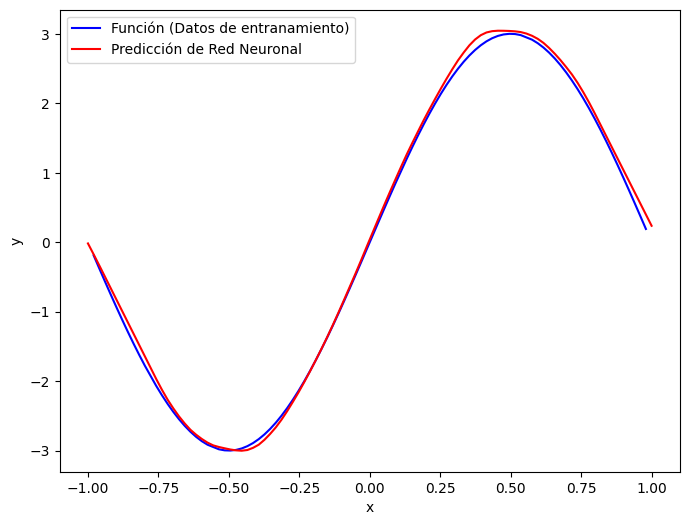

In [9]:
x_pred = np.linspace(-1, 1, 100).reshape(-1, 1)
y_pred = model.predict(x_pred)


plt.figure(figsize=(8, 6))
plt.plot(x_test, y_test, color='blue', label='Función (Datos de entranamiento)')
plt.plot(x_pred, y_pred, color='red', label='Predicción de Red Neuronal')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

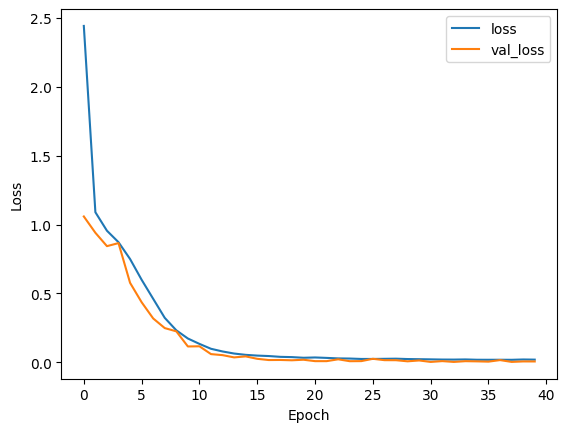

In [10]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
#Ejercicio 1(b): 
#Vamos a proponer los siguientes arreglos como conjuntos de entranmiento y de prueba 

x_train = np.linspace(-1, 1, 1000).reshape(-1, 1)
y_train = 1+2*x_train+4*np.power(x_train,3.)

#Eliminamos elementos repetidos entre el conjunto de entrenamiento y de prueba
v=np.linspace(-1, 1, 100)
cond=np.isin(np.linspace(-1, 1, 100),np.linspace(-1, 1, 1000))
v=v[np.where(~cond)]

x_test = v.reshape(-1, 1)
y_test = 1+2*x_test+4*np.power(x_test,3.)


In [12]:
model = Sequential()
model.add(Dense(300, activation='relu', input_shape=(1,)))
model.add(Dropout(0.2))
model.add(Dense(300, activation='relu'))
model.add(Dense(1))



In [ ]:
model = Sequential()
model.add(Dense(300, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(1,)))
model.add(Dropout(0.2))
model.add(Dense(300, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(1))

In [ ]:
batch_size=20 
epochs=30
learning_rate=0.01
Optimizador=SGD
import wandb
from wandb.keras import WandbCallback
wandb.init(project="Red_Neuronal_Ejercicio1b")
wandb.config.learning_rate = learning_rate
wandb.config.epochs = epochs
wandb.config.batch_size = batch_size
wandb.config.optimizador=Optimizador

In [14]:
model.compile(loss='mean_squared_error', optimizer=SGD(learning_rate=learning_rate), metrics=['mse'])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test),callbacks=[WandbCallback()])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/30
43/50 [========================>.....] - ETA: 0s - loss: 4.7209 - mse: 4.7209

wandb: Adding directory to artifact (/content/wandb/run-20230528_191114-2fedjzj2/files/model-best)... Done. 0.0s


50/50 [==============================] - 2s 29ms/step - loss: 4.1973 - mse: 4.1973 - val_loss: 1.0492 - val_mse: 1.0492
Epoch 2/30
43/50 [========================>.....] - ETA: 0s - loss: 0.8557 - mse: 0.8557

wandb: Adding directory to artifact (/content/wandb/run-20230528_191114-2fedjzj2/files/model-best)... Done. 0.0s


50/50 [==============================] - 1s 24ms/step - loss: 0.8303 - mse: 0.8303 - val_loss: 0.5593 - val_mse: 0.5593
Epoch 3/30
46/50 [==========================>...] - ETA: 0s - loss: 0.5821 - mse: 0.5821

wandb: Adding directory to artifact (/content/wandb/run-20230528_191114-2fedjzj2/files/model-best)... Done. 0.0s


50/50 [==============================] - 1s 28ms/step - loss: 0.5778 - mse: 0.5778 - val_loss: 0.4694 - val_mse: 0.4694
Epoch 4/30
46/50 [==========================>...] - ETA: 0s - loss: 0.5101 - mse: 0.5101

wandb: Adding directory to artifact (/content/wandb/run-20230528_191114-2fedjzj2/files/model-best)... Done. 0.0s


50/50 [==============================] - 2s 34ms/step - loss: 0.5036 - mse: 0.5036 - val_loss: 0.3372 - val_mse: 0.3372
Epoch 5/30
49/50 [============================>.] - ETA: 0s - loss: 0.4362 - mse: 0.4362

wandb: Adding directory to artifact (/content/wandb/run-20230528_191114-2fedjzj2/files/model-best)... Done. 0.0s


50/50 [==============================] - 2s 34ms/step - loss: 0.4355 - mse: 0.4355 - val_loss: 0.3018 - val_mse: 0.3018
Epoch 6/30
44/50 [=========================>....] - ETA: 0s - loss: 0.3884 - mse: 0.3884

wandb: Adding directory to artifact (/content/wandb/run-20230528_191114-2fedjzj2/files/model-best)... Done. 0.0s


50/50 [==============================] - 1s 23ms/step - loss: 0.3897 - mse: 0.3897 - val_loss: 0.2436 - val_mse: 0.2436
Epoch 7/30
49/50 [============================>.] - ETA: 0s - loss: 0.3257 - mse: 0.3257

wandb: Adding directory to artifact (/content/wandb/run-20230528_191114-2fedjzj2/files/model-best)... Done. 0.0s


50/50 [==============================] - 1s 29ms/step - loss: 0.3251 - mse: 0.3251 - val_loss: 0.2066 - val_mse: 0.2066
Epoch 8/30
47/50 [===========================>..] - ETA: 0s - loss: 0.2929 - mse: 0.2929

wandb: Adding directory to artifact (/content/wandb/run-20230528_191114-2fedjzj2/files/model-best)... Done. 0.0s


50/50 [==============================] - 1s 23ms/step - loss: 0.2920 - mse: 0.2920 - val_loss: 0.1862 - val_mse: 0.1862
Epoch 9/30
48/50 [===========================>..] - ETA: 0s - loss: 0.2665 - mse: 0.2665

wandb: Adding directory to artifact (/content/wandb/run-20230528_191114-2fedjzj2/files/model-best)... Done. 0.0s


50/50 [==============================] - 1s 22ms/step - loss: 0.2667 - mse: 0.2667 - val_loss: 0.1525 - val_mse: 0.1525
Epoch 10/30
36/50 [====================>.........] - ETA: 0s - loss: 0.2440 - mse: 0.2440

wandb: Adding directory to artifact (/content/wandb/run-20230528_191114-2fedjzj2/files/model-best)... Done. 0.0s


50/50 [==============================] - 1s 23ms/step - loss: 0.2278 - mse: 0.2278 - val_loss: 0.1310 - val_mse: 0.1310
Epoch 11/30
43/50 [========================>.....] - ETA: 0s - loss: 0.2148 - mse: 0.2148

wandb: Adding directory to artifact (/content/wandb/run-20230528_191114-2fedjzj2/files/model-best)... Done. 0.0s


50/50 [==============================] - 1s 22ms/step - loss: 0.2133 - mse: 0.2133 - val_loss: 0.1157 - val_mse: 0.1157
Epoch 12/30
48/50 [===========================>..] - ETA: 0s - loss: 0.1882 - mse: 0.1882

wandb: Adding directory to artifact (/content/wandb/run-20230528_191114-2fedjzj2/files/model-best)... Done. 0.0s


50/50 [==============================] - 1s 24ms/step - loss: 0.1875 - mse: 0.1875 - val_loss: 0.0996 - val_mse: 0.0996
Epoch 13/30
47/50 [===========================>..] - ETA: 0s - loss: 0.1685 - mse: 0.1685

wandb: Adding directory to artifact (/content/wandb/run-20230528_191114-2fedjzj2/files/model-best)... Done. 0.0s


50/50 [==============================] - 1s 23ms/step - loss: 0.1675 - mse: 0.1675 - val_loss: 0.0905 - val_mse: 0.0905
Epoch 14/30
50/50 [==============================] - ETA: 0s - loss: 0.1451 - mse: 0.1451

wandb: Adding directory to artifact (/content/wandb/run-20230528_191114-2fedjzj2/files/model-best)... Done. 0.0s


50/50 [==============================] - 1s 28ms/step - loss: 0.1451 - mse: 0.1451 - val_loss: 0.0847 - val_mse: 0.0847
Epoch 15/30
46/50 [==========================>...] - ETA: 0s - loss: 0.1435 - mse: 0.1435

wandb: Adding directory to artifact (/content/wandb/run-20230528_191114-2fedjzj2/files/model-best)... Done. 0.0s


50/50 [==============================] - 2s 35ms/step - loss: 0.1431 - mse: 0.1431 - val_loss: 0.0643 - val_mse: 0.0643
Epoch 16/30
47/50 [===========================>..] - ETA: 0s - loss: 0.1339 - mse: 0.1339

wandb: Adding directory to artifact (/content/wandb/run-20230528_191114-2fedjzj2/files/model-best)... Done. 0.0s


50/50 [==============================] - 2s 35ms/step - loss: 0.1352 - mse: 0.1352 - val_loss: 0.0572 - val_mse: 0.0572
Epoch 17/30
41/50 [=======================>......] - ETA: 0s - loss: 0.1090 - mse: 0.1090

wandb: Adding directory to artifact (/content/wandb/run-20230528_191114-2fedjzj2/files/model-best)... Done. 0.0s


50/50 [==============================] - 1s 23ms/step - loss: 0.1094 - mse: 0.1094 - val_loss: 0.0549 - val_mse: 0.0549
Epoch 18/30
50/50 [==============================] - ETA: 0s - loss: 0.1087 - mse: 0.1087

wandb: Adding directory to artifact (/content/wandb/run-20230528_191114-2fedjzj2/files/model-best)... Done. 0.0s


50/50 [==============================] - 2s 32ms/step - loss: 0.1087 - mse: 0.1087 - val_loss: 0.0451 - val_mse: 0.0451
Epoch 19/30
49/50 [============================>.] - ETA: 0s - loss: 0.0914 - mse: 0.0914

wandb: Adding directory to artifact (/content/wandb/run-20230528_191114-2fedjzj2/files/model-best)... Done. 0.0s


50/50 [==============================] - 1s 23ms/step - loss: 0.0915 - mse: 0.0915 - val_loss: 0.0384 - val_mse: 0.0384
Epoch 20/30
45/50 [==========================>...] - ETA: 0s - loss: 0.0848 - mse: 0.0848

wandb: Adding directory to artifact (/content/wandb/run-20230528_191114-2fedjzj2/files/model-best)... Done. 0.0s


50/50 [==============================] - 1s 24ms/step - loss: 0.0872 - mse: 0.0872 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 21/30
50/50 [==============================] - ETA: 0s - loss: 0.0855 - mse: 0.0855

wandb: Adding directory to artifact (/content/wandb/run-20230528_191114-2fedjzj2/files/model-best)... Done. 0.0s


50/50 [==============================] - 1s 24ms/step - loss: 0.0855 - mse: 0.0855 - val_loss: 0.0304 - val_mse: 0.0304
Epoch 22/30
41/50 [=======================>......] - ETA: 0s - loss: 0.0747 - mse: 0.0747

wandb: Adding directory to artifact (/content/wandb/run-20230528_191114-2fedjzj2/files/model-best)... Done. 0.0s


50/50 [==============================] - 1s 24ms/step - loss: 0.0802 - mse: 0.0802 - val_loss: 0.0256 - val_mse: 0.0256
Epoch 23/30
35/50 [====================>.........] - ETA: 0s - loss: 0.0758 - mse: 0.0758

wandb: Adding directory to artifact (/content/wandb/run-20230528_191114-2fedjzj2/files/model-best)... Done. 0.0s


50/50 [==============================] - 1s 23ms/step - loss: 0.0710 - mse: 0.0710 - val_loss: 0.0246 - val_mse: 0.0246
Epoch 24/30
44/50 [=========================>....] - ETA: 0s - loss: 0.0733 - mse: 0.0733

wandb: Adding directory to artifact (/content/wandb/run-20230528_191114-2fedjzj2/files/model-best)... Done. 0.0s


50/50 [==============================] - 1s 23ms/step - loss: 0.0720 - mse: 0.0720 - val_loss: 0.0215 - val_mse: 0.0215
Epoch 25/30
50/50 [==============================] - ETA: 0s - loss: 0.0669 - mse: 0.0669

wandb: Adding directory to artifact (/content/wandb/run-20230528_191114-2fedjzj2/files/model-best)... Done. 0.0s


50/50 [==============================] - 2s 34ms/step - loss: 0.0669 - mse: 0.0669 - val_loss: 0.0194 - val_mse: 0.0194
Epoch 26/30
45/50 [==========================>...] - ETA: 0s - loss: 0.0655 - mse: 0.0655

wandb: Adding directory to artifact (/content/wandb/run-20230528_191114-2fedjzj2/files/model-best)... Done. 0.0s


50/50 [==============================] - 2s 35ms/step - loss: 0.0651 - mse: 0.0651 - val_loss: 0.0185 - val_mse: 0.0185
Epoch 27/30
50/50 [==============================] - 0s 7ms/step - loss: 0.0590 - mse: 0.0590 - val_loss: 0.0187 - val_mse: 0.0187
Epoch 28/30
50/50 [==============================] - 0s 6ms/step - loss: 0.0543 - mse: 0.0543 - val_loss: 0.0198 - val_mse: 0.0198
Epoch 29/30
45/50 [==========================>...] - ETA: 0s - loss: 0.0461 - mse: 0.0461

wandb: Adding directory to artifact (/content/wandb/run-20230528_191114-2fedjzj2/files/model-best)... Done. 0.0s


50/50 [==============================] - 1s 24ms/step - loss: 0.0487 - mse: 0.0487 - val_loss: 0.0164 - val_mse: 0.0164
Epoch 30/30
50/50 [==============================] - 0s 5ms/step - loss: 0.0582 - mse: 0.0582 - val_loss: 0.0223 - val_mse: 0.0223


4/4 [==============================] - 0s 3ms/step


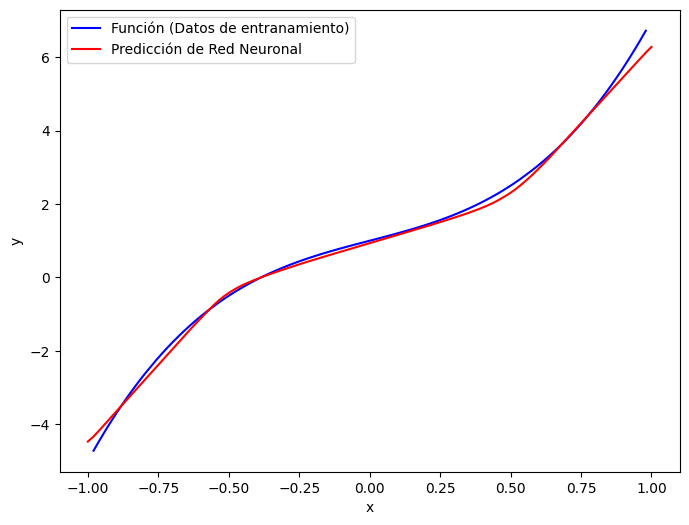

In [15]:
x_pred = np.linspace(-1, 1, 100).reshape(-1, 1)
y_pred = model.predict(x_pred)

plt.figure(figsize=(8, 6))
plt.plot(x_test, y_test, color='blue', label='Función (Datos de entranamiento)')
plt.plot(x_pred, y_pred, color='red', label='Predicción de Red Neuronal')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

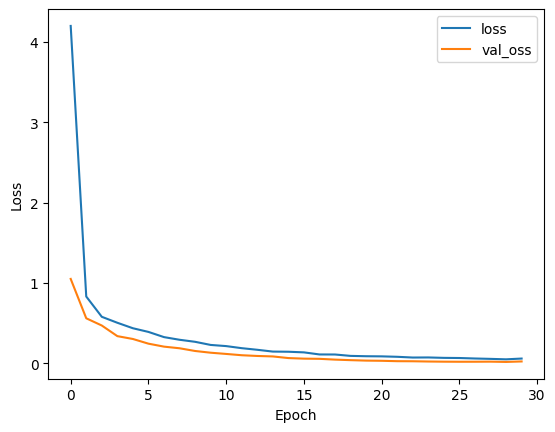

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_oss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
#Ejercicio dos: Identificar enfermedades en plantas 


In [18]:
#Para leer datos desde Google Drive: 
from google.colab import drive 
drive.mount('/content/drive') 

Mounted at /content/drive


In [19]:
df = pd.read_csv('/content/drive/MyDrive/Base de datos/train.csv', names=['Nombre', 'Clase'])

In [20]:
df=df.drop(0,axis=0)#Eliminamos la primera fila que no es d eutilidad

In [21]:
df.Clase.unique()#Checamos las etiquetas de las clases

array(['healthy', 'scab frog_eye_leaf_spot complex', 'scab', 'complex',
       'rust', 'frog_eye_leaf_spot', 'powdery_mildew',
       'scab frog_eye_leaf_spot', 'frog_eye_leaf_spot complex',
       'rust frog_eye_leaf_spot', 'powdery_mildew complex',
       'rust complex'], dtype=object)

In [22]:
df[df['Clase']=='healthy']['Nombre'].size

4624

In [23]:
for x in list(df.Clase.unique()): 
  y=df[df['Clase']==x]['Nombre'].size
  print(f'{x}={y}')

healthy=4624
scab frog_eye_leaf_spot complex=200
scab=4826
complex=1602
rust=1860
frog_eye_leaf_spot=3181
powdery_mildew=1184
scab frog_eye_leaf_spot=686
frog_eye_leaf_spot complex=165
rust frog_eye_leaf_spot=120
powdery_mildew complex=87
rust complex=97


In [24]:
df.shape

(18632, 2)

In [25]:
#Vamos a mezclar de manera aleatoria todas las filas del csv
#df= df.sample(frac=1, random_state=42)
#Vamos a dividir a la mitad la base de datos para la primera parte para imagenes de entrenamiento y la otra por prueba
#df1=df.iloc[0:9316,:]
#df2=df.iloc[9316:18633,:]

In [26]:
#Podemos notar que los conjuntos no tienen elementos en común 
#set(df1.Nombre).intersection(set(df2.Nombre))

In [27]:
# Ruta de la carpeta de destino para las subcarpetas
mini_train = '/content/train_'

# Crear la carpeta de destino si no existe
if not os.path.exists(mini_train ):
    os.makedirs(mini_train )

In [28]:
#Formamos una lista ordenada de las categorias de que tenemos en nuestro csv
E= df.sort_values('Clase')
clases= list(E.Clase.unique())

In [29]:
#El próposito de este for es formar carpetas de cada una de las clasificaciones en la carpeta llamada train_
#Cada carpeta consta de 50 imágenes con la finalidad de reducir el tiempo de aprendizaje de la red convolucional
for i in clases:
    contador = 0  # Contador de imágenes en la carpeta actual
    for c in list(df[df['Clase'] == i]['Nombre']):
        if contador >= 50:
            break  # Se alcanzó el límite de imágenes por carpeta
        imagen= os.path.join('/content/drive/MyDrive/Base de datos/train_images', c)
        if os.path.exists(imagen):
            mt= os.path.join(mini_train , 'train_' + i)
            if not os.path.exists(mt):
                os.makedirs(mt)
            m= shutil.copy(imagen,mt)
            contador+= 1



In [30]:
l=list(os.listdir('/content/train_'))


In [31]:
#Realizamos el mismo procedimiento para crear la carpeta con subcarpetas de las categorías del problema
#Esta vez para el conjunto de prueba 

# Ruta de la carpeta de destino para las subcarpetas
mini_test = '/content/test_'

# Crear la carpeta de destino si no existe
if not os.path.exists(mini_test):
    os.makedirs(mini_test )

In [32]:
#Formamos una lista ordenada de las categorias de que tenemos en nuestro csv
#E= df2.sort_values('Clase')
#clases= list(E.Clase.unique())

In [33]:
#El próposito de este for es formar carpetas de cada una de las clasificaciones en la carpeta llamada test_
#Cada carpeta consta de 5 imágenes,estamos considerado el 10% de las imagenes de entrenamiento.
for i in clases:
    contador = 0  # Contador de imágenes en la carpeta actual
    for c in list(df[df['Clase'] == i]['Nombre']):
        if contador >= 5:
            break  # Se alcanzó el límite de imágenes por carpeta
        imagen= os.path.join('/content/drive/MyDrive/Base de datos/train_images', c)
        if os.path.exists(imagen):
            mt= os.path.join(mini_test , 'test_' + i)
            if not os.path.exists(mt):
                os.makedirs(mt)
            m= shutil.copy(imagen,mt)
            contador+= 1


In [34]:
ih,iw=150,150 #Tamaño de la imagen
input_shape=(ih,iw,3) #forma de la imagen : Largo, Ancho y colores
train_dir= '/content/train_' #directorio de entrenamiento
test_dir='/content/test_' #directorio de prueba 
num_class=12 #Número de clases
epochs=30 #Epocas
batch_size=5  #batch para hacer cada entrenamiento. Lee 5 'batch_size' imagenes antes de actualizar
num_train= 600 #Número de imágenes en train 
num_test=60 #Número de imágenes en test
epoch_steps= num_train//batch_size 
test_steps=num_test//batch_size

In [35]:
h1=set(os.listdir(train_dir))
h2=set(os.listdir(test_dir))
l=h1.intersection(h2)
l

set()

In [36]:
gentrain = ImageDataGenerator(rescale=1. / 255., rotation_range=20,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.2) 
#Generamos más imágenes mediante rotaciones y traslaciones 

train = gentrain.flow_from_directory(train_dir,
                batch_size=batch_size,
                target_size=(iw, ih),
                class_mode='categorical',shuffle=True )

gentest = ImageDataGenerator(rescale=1. / 255)

test = gentest.flow_from_directory(test_dir,
                batch_size=batch_size,
                target_size=(iw, ih),
                class_mode='categorical',shuffle=True )

Found 600 images belonging to 12 classes.
Found 60 images belonging to 12 classes.


In [37]:
#shutil.rmtree('/content/train_') #Para eliminar una carpeta


In [38]:
#shutil.rmtree('/content/test_') #Para eliminar una carpeta

In [39]:
model=Sequential() 
model.add(Conv2D(10,(3,3),input_shape=(ih,iw,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(10,(3,3))) 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2))) 

model.add(Conv2D(20,(3,3))) 
model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size=(2,2))) 

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(64)) 
model.add(Activation('relu')) 
model.add(Dropout(0.2))
model.add(Dense(12)) 
model.add(Activation('softmax'))



In [40]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(ih, iw, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(12))
model.add(Activation('softmax'))

In [41]:
import wandb
from wandb.keras import WandbCallback
wandb.init(project="Red_Neuronal_Ejercicio1b")
wandb.config.learning_rate = 0.001
wandb.config.epochs = epochs
wandb.config.steps_per_epoch =epoch_steps
wandb.config.optimizador=RMSprop
wandb.config.validation_steps=test_steps

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mse,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse,█▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,28
best_val_loss,0.01639
epoch,29
loss,0.05824
mse,0.05824
val_loss,0.02228


In [42]:
loss= CategoricalCrossentropy()
model.compile(loss=loss, optimizer=RMSprop(learning_rate=0.001), metrics=['accuracy'])
model.fit(train, steps_per_epoch=epoch_steps, epochs=epochs, validation_data=test, validation_steps=test_steps,callbacks=[WandbCallback()])

Epoch 1/30
120/120 [==============================] - ETA: 0s - loss: 2.5153 - accuracy: 0.0650

wandb: Adding directory to artifact (/content/wandb/run-20230528_191618-by2r67yn/files/model-best)... Done. 2.5s


120/120 [==============================] - 184s 2s/step - loss: 2.5153 - accuracy: 0.0650 - val_loss: 2.4670 - val_accuracy: 0.1000
Epoch 2/30
 69/120 [================>.............] - ETA: 1:05 - loss: 2.4863 - accuracy: 0.0870

KeyboardInterrupt: ignored